##### Reference: https://towardsdatascience.com/making-your-own-discover-weekly-f1ac7546fedb

---------------------------------------------------------------------------------------

# Spotify Discover Weekly

My goal with this project was to familiarize myself with the Spotify API and to apply machine learning classification algorithms to create my own Discover Weekly playlist.


To do so, I made two playlists:

        Good Songs: songs I actually like (1,056 songs)
        Bad Songs: songs I don't like (990 songs)
        
Collecting the data took much longer than figuring out how to communicate with the API since my actual music library, which has over 10K songs, is on Apple Music :(

In [4]:
# Packages
import spotipy 
from spotipy.oauth2 import SpotifyClientCredentials
import spotipy.util as util
import pandas as pd
import numpy as np

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

from matplotlib import pyplot as plt
import seaborn as sns

import graphviz
import pydotplus
import io

from scipy import misc
from sklearn.metrics import accuracy_score


## Set up API

In [12]:
cid = "79ddadb243e64a42be83fb63751061e3"
secret = "c33781fb65cd4eaeafc095c2a7132184"
username = "1240047525"

client_credentials_manager = SpotifyClientCredentials(client_id = cid,
        client_secret = secret)

sp = spotipy.Spotify(client_credentials_manager = client_credentials_manager)

scope = "user-library-modify playlist-modify-public playlist-modify-private"
token = util.prompt_for_user_token(username,scope,client_id=cid,client_secret=secret,redirect_uri = "http://localhost:8888")


if token:
    sp = spotipy.Spotify(auth=token)
else: 
    print("can't get token for ", username)

##### Yay for json output

In [3]:
sp.current_user_playlists()

{'href': 'https://api.spotify.com/v1/users/1240047525/playlists?offset=0&limit=50',
 'items': [{'collaborative': False,
   'description': 'The best of country!! Updated every Friday with top hits from well known and up and coming country artists!! Toss a follow on this playlist and dont forget to share it! Hint: Sort by date added to get the most recently added!',
   'external_urls': {'spotify': 'https://open.spotify.com/playlist/7d85RPHimZb0gR4PlY3IKq'},
   'href': 'https://api.spotify.com/v1/playlists/7d85RPHimZb0gR4PlY3IKq',
   'id': '7d85RPHimZb0gR4PlY3IKq',
   'images': [{'height': None,
     'url': 'https://i.scdn.co/image/ab67706c0000da843cbd7500d95837eb907b3cd6',
     'width': None}],
   'name': 'Top Country Hits (Updated Weekly)',
   'owner': {'display_name': 'Seaon C Regis-Linteau',
    'external_urls': {'spotify': 'https://open.spotify.com/user/seaon09'},
    'href': 'https://api.spotify.com/v1/users/seaon09',
    'id': 'seaon09',
    'type': 'user',
    'uri': 'spotify:user

In [8]:
playlist_ids= ["7d85RPHimZb0gR4PlY3IKq?si=Y1MeYEFIRZ-TBjPXJP8bbA","52Q1YxoDwumE5kVZ5RjSv4?si=a2yGQr3IQHOiB3Wuqg-1Ew"
               ,"37i9dQZF1DWUgX5cUT0GbU?si=6qk16-WwSRizDzYvHZIN2g","37i9dQZF1DWViXqZVTGO3Z?si=VnUBc162TjijyU4g0Bb80w"
               ,"37i9dQZF1DX2zsdpDHp0xI?si=otSpGk--RZCRU9h-g07sjA","37i9dQZF1DX4JAvHpjipBk?si=bEX6B75VSLKFQUlp1MwPgw"
               ,"38OyccSqC4IrY2JnmGzgPZ?si=fNIZ3PNaRdWvNXg0innNUQ","37i9dQZF1DZ06evO2cV1FC?si=ggotUeZWQOOPtUWcW6Ps8w"
               ,"37i9dQZF1DXe5osTANjnfx?si=mJda6konQ0u4YUwn0XRfYg","1tPWTwuxOLsE2Do1JQSUxA?si=XJxpVeaqRBafZCb-0aXVLg"
               ,"5nScslhDjxqWjRhhvAmYZv?si=_qD613ToQeakvxMiExiBsA"]

for playlist in playlist_ids:
    sourcePlaylist = sp.user_playlist("1240047525",playlist)
    tracks = sourcePlaylist["tracks"]
    songs = tracks["items"]
    while tracks["next"]:
        tracks = sp.next(tracks)
        for item in tracks["items"]:
            songs.append(item)
    ids = []
    print(len(songs))
    print(songs[0]['track']['id'])
    i = 0
    for i in range(len(songs)):
        sp.user_playlist_add_tracks("1240047525","75AqhOZrKK8p57gqPufZPg",[songs[i]["track"]["id"]])
        #bad list https://open.spotify.com/playlist/75AqhOZrKK8p57gqPufZPg?si=XRygOTc_SwCRj_pLAGne5A 

# Feature Extraction

I extracted the following features from songs I like and dislike to analyze how or if there is a significant difference or trend between the two classes:

        tempo
        danceability
        duration_ms
        loudness
        speechiness
        valence
        energy
        acousticness
        key
        instrumentalness

In [7]:
good_playlist = sp.user_playlist("1240047525","5IgF6LOJlnlKKnNLiEJeUl")

bad_playlist = sp.user_playlist("1240047525","75AqhOZrKK8p57gqPufZPg")

In [8]:
good_tracks = good_playlist["tracks"]
good_songs = good_tracks["items"]
while good_tracks["next"]:
    good_tracks = sp.next(good_tracks)
    for item in good_tracks["items"]:
        good_songs.append(item)
good_ids = []
print(len(good_songs))
for i in range(len(good_songs)): ## Using all the data for now
    good_ids.append(good_songs[i]['track']['id'])

1057


In [9]:
bad_tracks = bad_playlist["tracks"]
bad_songs = []
bad_songs = bad_tracks['items']
while bad_tracks["next"]:
    bad_tracks = sp.next(bad_tracks)
    for item in bad_tracks['items']:
        bad_songs.append(item)
bad_ids = []
print(len(bad_songs))
for i in range(len(bad_songs)):
    bad_ids.append(bad_songs[i]['track']['id'])

1002


In [13]:
features = []
inSavedTracks = []
j = 0
for i in range(0,len(good_ids),50):
    audio_features = sp.audio_features(good_ids[i:i+50])
    for track in audio_features:
        features.append(track)
        track = good_songs[j]
        j = j + 1
        features[-1]['trackPopularity'] = track['track']['popularity']
        features[-1]['artistPopularity'] = sp.artist(track['track']['artists'][0]['id'])['popularity']
        
        features[-1]['target'] = 1 # updalte last row for class 1
j = 0
for i in range(0,len(bad_ids),50):
    audio_features = sp.audio_features(bad_ids[i:i+50])
    for track in audio_features:
        features.append(track)
        track = bad_songs[j]
        j = j + 1
        features[-1]['trackPopularity'] = track['track']['popularity']
        features[-1]['artistPopularity'] = sp.artist(track['track']['artists'][0]['id'])['popularity']
        
        features[-1]['target'] = 0 # updalte last row for class 1


# Data Exploration

In [14]:
trainingData = pd.DataFrame(features)

In [33]:
train,test = train_test_split(trainingData, test_size = 0.15)
print("Training size: {}, Test size: {}".format(len(train),len(test)))

Training size: 1750, Test size: 309


In [35]:
red_blue = ['#19B5FE', '#EF4836']
palette = sns.color_palette(red_blue)
sns.set_palette(palette)
sns.set_style('white')

In [36]:
pos_tempo = trainingData[trainingData['target'] == 1]['tempo']
neg_tempo = trainingData[trainingData['target'] == 0]['tempo']
pos_dance = trainingData[trainingData['target'] == 1]['danceability']
neg_dance = trainingData[trainingData['target'] == 0]['danceability']
pos_duration = trainingData[trainingData['target'] == 1]['duration_ms']
neg_duration = trainingData[trainingData['target'] == 0]['duration_ms']
pos_loudness = trainingData[trainingData['target'] == 1]['loudness']
neg_loudness = trainingData[trainingData['target'] == 0]['loudness']
pos_speechiness = trainingData[trainingData['target'] == 1]['speechiness']
neg_speechiness = trainingData[trainingData['target'] == 0]['speechiness']
pos_valence = trainingData[trainingData['target'] == 1]['valence']
neg_valence = trainingData[trainingData['target'] == 0]['valence']
pos_energy = trainingData[trainingData['target'] == 1]['energy']
neg_energy = trainingData[trainingData['target'] == 0]['energy']
pos_acousticness = trainingData[trainingData['target'] == 1]['acousticness']
neg_acousticness = trainingData[trainingData['target'] == 0]['acousticness']
pos_key = trainingData[trainingData['target'] == 1]['key']
neg_key = trainingData[trainingData['target'] == 0]['key']
pos_instrumentalness = trainingData[trainingData['target'] == 1]['instrumentalness']
neg_instrumentalness = trainingData[trainingData['target'] == 0]['instrumentalness']
pos_popularity = trainingData[trainingData['target'] == 1]['trackPopularity']
neg_popularity = trainingData[trainingData['target'] == 0]['trackPopularity']

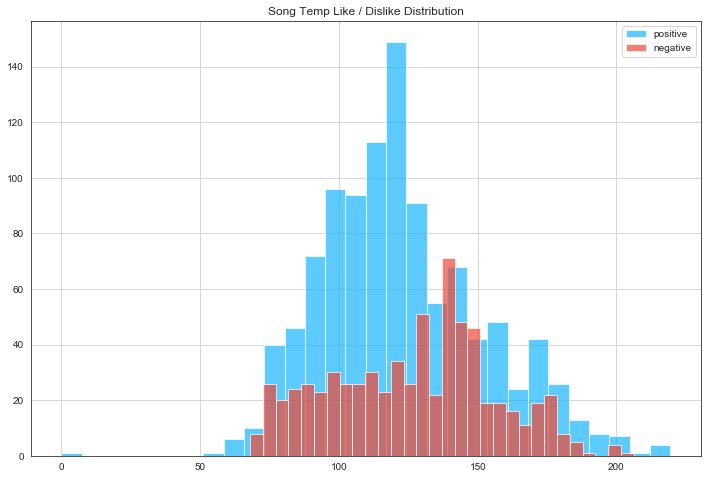

In [40]:
fig = plt.figure(figsize=(12,8))
plt.title("Song Temp Like / Dislike Distribution")
pos_tempo.hist(alpha=0.7,bins=30,label='positive')
neg_tempo.hist(alpha=0.7,bins=30,label='negative')
plt.legend(loc='upper right')

######  Figure 1: <center>  Hmmm... seems I'm into much  cheerful music than I thought. </center>

/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
/Users/rubinakabir/minicon

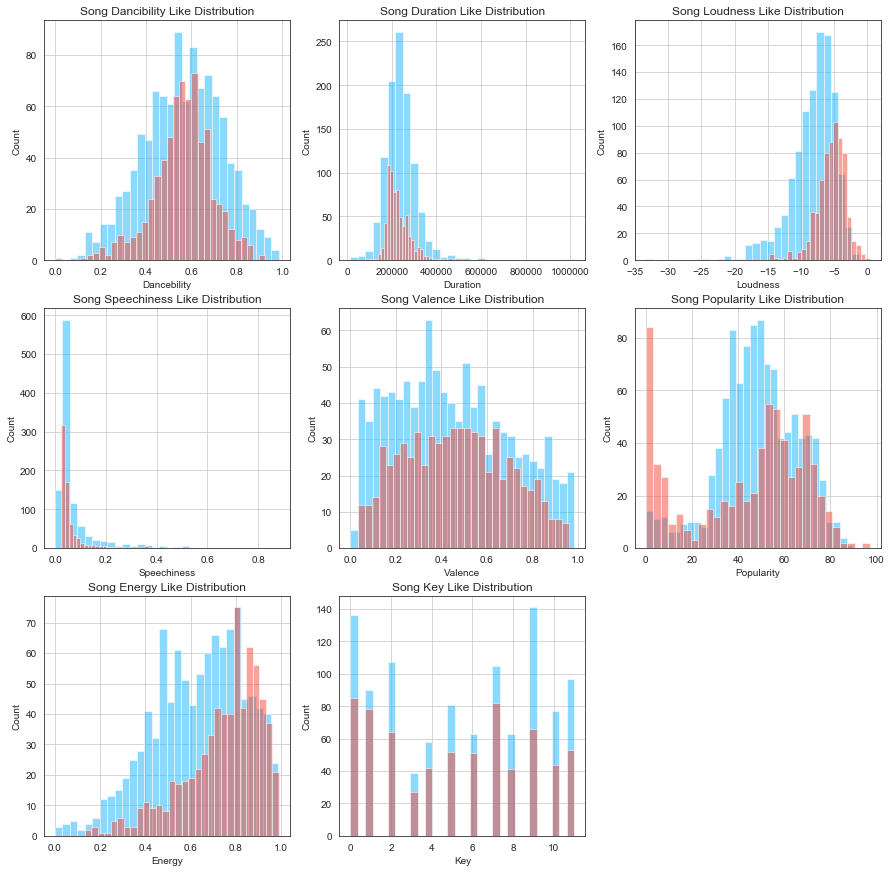

In [46]:
fig2 = plt.figure(figsize=(15,15))

# Dancebility
ax3 = fig2.add_subplot(331)
ax3.set_xlabel("Dancebility")
ax3.set_ylabel('Count')
ax3.set_title("Song Dancibility Like Distribution")
pos_dance.hist(alpha=0.5,bins=30)
ax4 = fig2.add_subplot(331)
neg_dance.hist(alpha=0.5,bins=30)

# Duration_ms
ax5 = fig2.add_subplot(332)
ax5.set_xlabel("Duration")
ax5.set_ylabel('Count')
ax5.set_title("Song Duration Like Distribution")
pos_duration.hist(alpha=0.5,bins=30)
ax6 = fig2.add_subplot(332)
neg_duration.hist(alpha=0.5,bins=30)

# Loudness
ax7 = fig2.add_subplot(333)
ax7.set_xlabel("Loudness")
ax7.set_ylabel('Count')
ax7.set_title("Song Loudness Like Distribution")
pos_loudness.hist(alpha=0.5,bins=30)
ax8 = fig2.add_subplot(333)
neg_loudness.hist(alpha=0.5,bins=30)

# Speechiness
ax9 = fig2.add_subplot(334)
ax9.set_xlabel("Speechiness")
ax9.set_ylabel('Count')
ax9.set_title("Song Speechiness Like Distribution")
pos_speechiness.hist(alpha=0.5,bins=30)
ax10 = fig2.add_subplot(334)
neg_speechiness.hist(alpha=0.5,bins=30)

# Valence
ax11 = fig2.add_subplot(335)
ax11.set_xlabel("Valence")
ax11.set_ylabel('Count')
ax11.set_title("Song Valence Like Distribution")
pos_valence.hist(alpha=0.5,bins=30)
ax12 = fig2.add_subplot(335)
neg_valence.hist(alpha=0.5,bins=30)

# Energy
ax13 = fig2.add_subplot(337)
ax13.set_xlabel("Energy")
ax13.set_ylabel('Count')
ax13.set_title("Song Energy Like Distribution")
pos_energy.hist(alpha=0.5,bins=30)
ax14 = fig2.add_subplot(337)
neg_energy.hist(alpha=0.5,bins=30)

# Key
ax15 = fig2.add_subplot(338)
ax15.set_xlabel("Key")
ax15.set_ylabel('Count')
ax15.set_title("Song Key Like Distribution")
pos_key.hist(alpha=0.5,bins=30)
ax16 = fig2.add_subplot(338)
neg_key.hist(alpha=0.5,bins=30)

# Popularity
ax17 = fig2.add_subplot(336)
ax17.set_xlabel("Popularity")
ax17.set_ylabel('Count')
ax17.set_title("Song Popularity Like Distribution")
pos_popularity.hist(alpha=0.5,bins=30)
ax18 = fig2.add_subplot(336)
neg_popularity.hist(alpha=0.5,bins=30)


######  Figure 2: <center> I can conclude that there is an okay distinction between the classes for each feature. </center>

# Machine Learning Techniques
Supervised and Unsupervised

Here, I will used various methods: 

        Decision Tree
        K-Nearest Neighbors
        Multi-layer Perceptron Neural Network
        Random Forest
        AdaBoost
        Naive Bayes
        Kmeans
        Gradient Boosting 
        
from the sklearn Python package and I will use the method that performed the best to create the Discover Weekly playlist.

In [16]:
features = ["danceability", "loudness", "valence", "energy", "instrumentalness", "acousticness", "key", "speechiness","duration_ms"]

In [34]:
x_train = train[features]
y_train = train['target']

x_test = test[features]
y_test = test['target']

## Decision Tree Classifer

In [35]:
c = DecisionTreeClassifier(min_samples_split=100)
dt = c.fit(x_train,y_train)


In [ ]:
def show_tree(InputTree,features,path):
    f = io.StringIO()
    tree.export_graphviz(InputTree,out_file=f,feature_names=features)
    pydotplus.graph_from_dot_data(f.getvalue())
    img = misc.imread(path)
    plt.rcParams['figure.figsize'] = (20,20)
    plt.imshow(img)
show_tree(dt,features,"dec_tree.png")

In [36]:
y_pred = dt.predict(x_test)
score = accuracy_score(y_test,y_pred)*100
print("Accuracy score using Decision Tree",score)

Accuracy score using Decision Tree 72.81553398058253


# KNN 

In [37]:
from sklearn.neighbors import KNeighborsClassifier as knn
kn = knn(3).fit(x_train,y_train)
knn_pred = kn.predict(x_test)
score = accuracy_score(y_test,knn_pred)*100
print("Accuracy using KNN ", score)

Accuracy using KNN  56.957928802588995


# MLP

In [38]:
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier()
mlp.fit(x_train,y_train)
mlp_pred = mlp.predict(x_test)
score = accuracy_score(y_test,mlp_pred)*100
print("Accuracy using MLP", score)


Accuracy using MLP 52.42718446601942


/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


# Random Forest

In [42]:
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(max_depth = 5, n_estimators=10,max_features=1)
forest.fit(x_train,y_train)
forest_pred = forest.predict(x_test)
score = accuracy_score(y_test,forest_pred)*100
print("Accuracy using Random Forest ", score)

Accuracy using Random Forest  75.72815533980582


# AdaBoost

In [43]:
from sklearn.ensemble import AdaBoostClassifier
ada = AdaBoostClassifier(n_estimators=100)
ada.fit(x_train,y_train)
ada_pred = ada.predict(x_test)
score = accuracy_score(y_test,ada_pred)*100
print("Accuracy Score using ADABoost ",score)

Accuracy Score using ADABoost  74.4336569579288


# NaiveBayes

In [44]:
from sklearn.naive_bayes import GaussianNB
gauss = GaussianNB()
gauss.fit(x_train,y_train)
gauss_pred = gauss.predict(x_test)
score = accuracy_score(y_test,gauss_pred)*100
print("Accuracy using Naive Bayes ", score)

Accuracy using Naive Bayes  62.45954692556634


# KMeans

In [45]:
from sklearn.cluster import KMeans
k_means = KMeans(n_clusters=3,random_state=0)
k_means.fit(x_train,y_train)
k_pred = k_means.predict(x_test)
score = accuracy_score(y_test,k_pred)*100
print("Accuracy using Kmeans (3) ", score)

Accuracy using Kmeans (3)  55.98705501618123


# Gradient Boosting

In [46]:
from sklearn.ensemble import GradientBoostingClassifier
gbc = GradientBoostingClassifier(n_estimators = 100, learning_rate = 0.1,
                        max_depth = 1,random_state=0)
gbc.fit(x_train,y_train)
gbc_pred = gbc.predict(x_test)
score = accuracy_score(y_test,gbc_pred) * 100
print("Accuracy using Gradient Boosting Tree ", score )

Accuracy using Gradient Boosting Tree  76.05177993527508


###### Table 1:
<table> <tbody>
    <tr> <th> <center>Method </center> </th> <th> <center>Accuracy </center></th> </tr>
    <tr> <td> <div align = "left"> Decision Tree </div></td> <td> <div align = "left">72.82 </div></td> </tr>
    <tr> <td> <div align = "left">K-Nearest Neighbor </td> <td> <div align = "left">56.96 </div></td> </tr>
    <tr> <td> <div align = "left">Multi-layer Perceptron Neural Network </div></td> <td> <div align = "left">52.43 </div></td> </tr>
    <tr> <td> <div align = "left">Random Forest </div></td> <td> <div align = "left">75.73 </div></td> </tr>
    <tr> <td> <div align = "left">AdaBoost </div></td> <td> <div align = "left">74.43 </div></td> </tr>
    <tr> <td> <div align = "left">Naive Bayes </div></td> <td> <div align = "left">62.46 </div></td> </tr>
    <tr> <td> <div align = "left">Kmeans </div></td> <td> <div align = "left">55.99 </div></td> </tr>
    <tr> <td> <div align = "left">Gradient Boosting </div></td> <td> <div align = "left">76.05 </div></td> </tr>
    </tbody> </table>
    


# Creating the Playlist


Based off Table 1, I will create the Discover Weekly playlist using the Gradient Booster classifier.

Obviously, I should've carefully selected my model for creating the playlist, but my goal was to become familiar with the Spotify API.

I just grabbed an indie playlist on Spotify since that's what I like most. The playlist had 83 songs total and reccommended 67 of those songs to me.

In [82]:
playlistToFindSongsYouLikeIn = sp.user_playlist("spotify", "37i9dQZF1DX26DKvjp0s9M")
# https://open.spotify.com/playlist/37i9dQZF1DX26DKvjp0s9M?si=LU2uOHydSsGyD4xVc_mGhQ
#https://open.spotify.com/playlist/4b3bAnRKhM48QmSNmAIstQ?si=r9BY7jjzSBSWE793cNuFRQ

newPlaylist_tracks = playlistToFindSongsYouLikeIn['tracks']
newPlaylist_songs = newPlaylist_tracks['items']

while newPlaylist_tracks['next']:
    newPlaylist_tracks = sp.next(newPlaylist_tracks)
    for song in newPlaylist_tracks['items']:
        newPlaylistSongs.append(song)
        
newPlaylist_song_ids = []
print(len(newPlaylist_songs))
for i in range(len(newPlaylist_songs)):
    newPlaylist_song_ids.append(newPlaylist_songs[i]['track']['id'])
    
newPlaylist_features=[]
j = 0
for i in range(0,len(newPlaylist_song_ids),50):
    audio_features = sp.audio_features(newPlaylist_song_ids[i:i+50])
    for track in audio_features:
        track['song_title'] = newPlaylist_songs[j]['track']['name']
        track['artist'] = newPlaylist_songs[j]['track']['artists'][0]['name']
        j = j + 1
        newPlaylist_features.append(track)
print(len(newPlaylist_features))

playlistToLookAtFeatures = pd.DataFrame(newPlaylist_features)





83
83


In [73]:
newplaylist = sp.user_playlist_create("1240047525", "API Test Playlist", public=True)



In [59]:
playlistToLookAtFeatures['uri'][i]

'spotify:track:2cN7H31DES22HCjYitKggF'

In [74]:
pred = gbc.predict(playlistToLookAtFeatures[features])
likedSongs = 0
i = 0
for prediction in pred:
    if (prediction == 1):
        print("Song: "+ playlistToLookAtFeatures["song_title"][i] +" \n\tBy: "+ playlistToLookAtFeatures["artist"][i])
        likedSongs = likedSongs + 1
    i = i + 1

Song: Round And Round 
	By: Ariel Pink
Song: Holocene 
	By: Bon Iver
Song: Crystalised 
	By: The xx
Song: Helicopter 
	By: Deerhunter
Song: Hunnybee 
	By: Unknown Mortal Orchestra
Song: Two Weeks 
	By: Grizzly Bear
Song: San Francisco 
	By: Foxygen
Song: Pretty Pimpin 
	By: Kurt Vile
Song: Lemon Glow 
	By: Beach House
Song: Someone Great 
	By: LCD Soundsystem
Song: Archie, Marry Me 
	By: Alvvays
Song: Baby 
	By: Ariel Pink
Song: New Beat 
	By: Toro y Moi
Song: Seasons (Waiting On You) 
	By: Future Islands
Song: So Good at Being in Trouble 
	By: Unknown Mortal Orchestra
Song: Dance Yrself Clean 
	By: LCD Soundsystem
Song: Genesis 
	By: Grimes
Song: Ode to Viceroy 
	By: Mac DeMarco
Song: Eventually 
	By: Tame Impala
Song: Gronlandic Edit 
	By: of Montreal
Song: Tailwhip 
	By: Men I Trust
Song: Real Love Baby 
	By: Father John Misty
Song: Lazuli 
	By: Beach House
Song: Salad Days 
	By: Mac DeMarco
Song: Inside Out 
	By: Spoon
Song: Where'd All the Time Go? 
	By: Dr. Dog
Song: Myth 
	By: B

In [83]:
sp.user_playlist_add_tracks("1240047525", "0IPXA4GqngGNcYTpB51U1C", playlistToLookAtFeatures['id'])

{'snapshot_id': 'Myw0NGEzNjE1YWE0Yzk2NDc5NGVhZjE0YTNhODYyZTliNDI4NDM2YjYw'}

# Conclusions

After adding all the songs my classifier reccommended, I found 2 new songs that I actually never knew (I knew nearly all songs on the playlist I ended up selecting already). 


Future work would include adding more songs to my 'Good' and 'Bad' playlists to  improve the accuracy on the classifiers. In addition, I would implement the ML techniques carefully by implementing CV and also trying other classification methods.